In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import warnings

# 모든 FutureWarning 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-05-05 10:28:02.058142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746440882.069023   24355 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746440882.072138   24355 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [20]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images, images_test = list(), list()
    spots, spots_test = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = (np.array(train_images[slide_name]) * 255).astype('uint8')
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
            """if slide_name == 'S_1':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 50,
                    y = lambda x: x['y'] - 50,
                )
            el"""
            if slide_name == 'S_2':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 60,
                    y = lambda x: x['y'] - 60,
                )
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = (np.array(test_images[sample]) * 255).astype('uint8')
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images_test.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots_test.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = 0))
    # EfficientNet의 형식으로 바꿉니다.
    with tf.device('/CPU:0'):
        images = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images))
    df_spots = pd.concat(spots).reset_index(drop = True)
    with tf.device('/CPU:0'):
        images_test = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images_test))
    df_spots_test = pd.concat(spots_test).reset_index(drop = True)
    return images, df_spots, images_test, df_spots_test

def make_img_proc_info(df, img_with, img_height):
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )

def create_tf_ds(df):
    if (pd.Series(targets).isin(df.columns)).all():
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[targets2])
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X, images):
    return tf.cast(tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    ), tf.float32) / 255.0

augmentation_layers = [
    #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    #tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

images, df_spots, images_test, df_spots_test = load_data("data/elucidata_ai_challenge_data.h5")
targets = [i for i in df_spots.columns if i.startswith('C')]
n_components = 35
target_proc =  FunctionTransformer(lambda x: np.log(x).values, np.exp).fit(df_spots[targets])
target_proc.fit(df_spots[targets])
targets2 = ['C{}_l'.format(i + 1) for i in range(n_components)]
df_spots= df_spots.join(
    pd.DataFrame(target_proc.transform(df_spots[targets]), index = df_spots.index, columns = targets2)
)

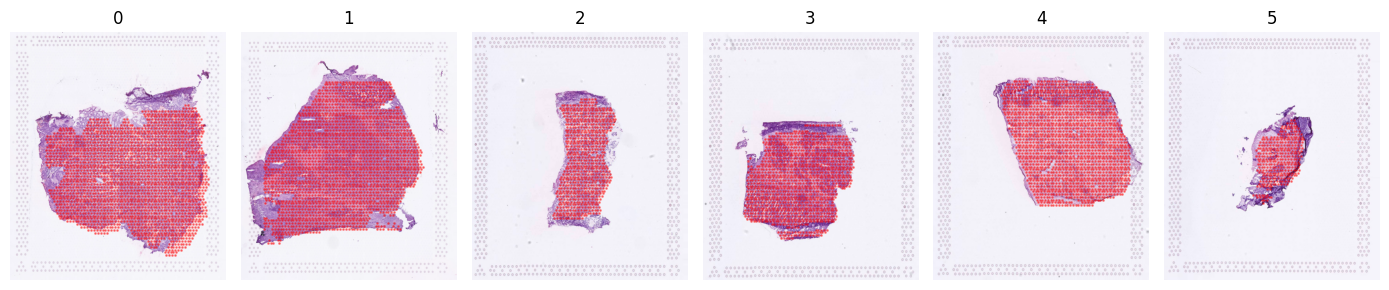

In [21]:
fig, ax = plt.subplots(1, 6, figsize=(14, 3))
for i, slide_name in enumerate(range(6)):
    image = images[i]
    x, y = df_spots.loc[df_spots['slide'] == i, "x"], df_spots.loc[df_spots['slide'] == i, "y"]

    ax[i].imshow(image, aspect="auto")
    ax[i].scatter(x, y, color="red", s=1, alpha=0.4)  # Overlay spot locations
    ax[i].set_title(slide_name)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [22]:
df_spots['slide'].unique()

array([0, 1, 2, 3, 4, 5])

In [23]:
import tensorflow as tf
from tensorflow.keras import layers

# 경량화된 MBConv block
def mbconv_block(x, in_channels, out_channels, expand_ratio, strides):
    hidden_dim = in_channels * expand_ratio
    residual = x

    if expand_ratio != 1:
        x = tf.keras.layers.Conv2D(hidden_dim, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Residual connection (only if shape matches and stride == 1)
    if strides == 1 and in_channels == out_channels:
        x = tf.keras.layers.Add()([x, residual])

    return x

# CIFAR-10 경량 EfficientNet
def efficientnet_16x(input_shape=(16, 16, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial conv (no downsampling)
    x = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # MBConv blocks (small and light)
    x = mbconv_block(x, 16, 24, expand_ratio=1, strides=1)    # 16x16
    x = mbconv_block(x, 24, 24, expand_ratio=1, strides=1)

    x = mbconv_block(x, 24, 32, expand_ratio=2, strides=2)    # 16x16 → 8x8
    x = mbconv_block(x, 32, 32, expand_ratio=2, strides=1)

    x = mbconv_block(x, 32, 48, expand_ratio=2, strides=2)    # 8x8 → 4x4
    x = mbconv_block(x, 48, 48, expand_ratio=2, strides=1)

    # Final conv
    x = tf.keras.layers.Conv2D(96, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Classification head
    return tf.keras.models.Model(inputs, tf.keras.layers.GlobalAveragePooling2D()(x))

In [24]:
from scipy.stats import spearmanr

def create_model(img_width, img_height):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    enet = efficientnet_16x(input_shape)
    enet.trainable = True
    """
    for i in enet.layers:
        if not isinstance(i, tf.keras.layers.BatchNormalization):
            i.trainable = True
    """
    x = enet(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'HeUniform')
    x = d1(x)
    d2 = tf.keras.layers.Dense(len(targets2))
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

def reconstruct_model(layers):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    x = layers[0](inputs, training = True)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = layers[1](x)
    outputs = layers[2](x)
    m = tf.keras.models.Model(inputs, outputs)
    return m

def train_model(
        m, train_idx, valid_idx, learning_rate, 
        target_proc = FunctionTransformer(lambda x: x, lambda x: x), 
        batch_size = 32, epochs = 20, step = ''
    ):

    ds_cv_train = create_tf_ds(
        df_spots.iloc[train_idx].pipe(
            lambda x: pd.concat([
                x, x.sample(n = batch_size - (len(x) % batch_size))
            ])
        )
    ).shuffle(5000).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).map(
        lambda X, Y: (data_augmentation(X), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

    ds_cv_prd = create_tf_ds(
        df_spots.iloc[train_idx]
    ).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    
    if valid_idx is not None:
        ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
            lambda X, Y: (proc_images(X, images), Y)
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    else:
        ds_valid = None
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=6000,
        alpha=0.1
    )
#    lr_schedule = learning_rate
    m.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        metrics = [tf.keras.metrics.MeanSquaredError()]
    )

    df_true_train = df_spots.iloc[train_idx][targets]
    if valid_idx is not None:
        df_true = df_spots.iloc[valid_idx][targets]
    else:
        df_true = None
    progress_bar = tqdm(total = epochs, desc=step)
    scores_train, scores_valid = list(), list()
    df_prd = None
    for i in range(epochs):
        hist = m.fit(ds_cv_train, epochs = 1, verbose = 0)
        df_prd = pd.DataFrame(
            target_proc.inverse_transform(m.predict(ds_cv_prd, verbose = 0)), 
            index = df_true_train.index, columns = targets
        )
        scores_train.append(
            df_true_train.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
        )
        metric = "train coef: {:.4f}".format(scores_train[-1])
        if valid_idx is not None:
            df_prd = pd.DataFrame(
                target_proc.inverse_transform(m.predict(ds_valid, verbose = 0)), 
                index = df_true.index, columns = targets
            )
            scores_valid.append(
                df_true.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
            )
            metric = metric + ", valid coef: {:.4f}".format(scores_valid[-1])
        progress_bar.set_postfix_str(metric)
        progress_bar.update(1)
    progress_bar.close()
    return (scores_train, scores_valid), df_prd

# Validation

In [25]:
img_width = 16
img_height = 16
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [26]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[targets], groups = df_spots['slide'])
):
    m, layers = create_model(img_width, img_height)
    score_1, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 5e-5, 
        target_proc = target_proc, batch_size = 32, epochs = 20, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(df_prd)
df_oof = pd.concat(oofs, axis = 0)

train 0:   0%|          | 0/20 [00:00<?, ?it/s]

train 1:   0%|          | 0/20 [00:00<?, ?it/s]

train 2:   0%|          | 0/20 [00:00<?, ?it/s]

train 3:   0%|          | 0/20 [00:00<?, ?it/s]

train 4:   0%|          | 0/20 [00:00<?, ?it/s]

train 5:   0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
from scipy.stats import spearmanr
df_oof[targets].groupby(df_spots['slide']).apply(
    lambda x: x.apply(lambda x: spearmanr(df_spots.loc[x.name, targets], x)[0], axis = 1).mean()
)

slide
0    0.338602
1    0.561828
2    0.550467
3    0.464493
4    0.287869
5    0.500244
dtype: float64

In [28]:
from scipy.stats import spearmanr
df_oof[targets].apply(
    lambda x: spearmanr(df_spots.loc[x.name, targets], x)[0], axis=1
).mean()

0.4308624827341405

In [29]:
joblib.dump((df_oof, scores), 'result/log_enet_16x16_S2_mse.joblib')

['result/log_enet_16x16_S2_mse.joblib']

# Train

In [9]:
img_width = 16
img_height = 16
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [10]:
m, layers = create_model(img_width, img_height)
score_1, df_prd = train_model(
    m, df_spots.index, None, learning_rate = 1e-7, 
    target_proc = target_proc, batch_size = 32, epochs = 10, step = 'train'
)

train:   0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
joblib.dump(m.get_weights(), 'model/log_enet_16x16_S2_mse.joblib')

['model/log_std_pca_5_eff_b0_pre_fine_S2_mse.joblib']